In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

save = True

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [96]:
cut_based = ["dr_bf_c", "dr_ob_c", "dr_aov_c", "dr_bsa_c", "dr_sc_c", "ds_bf_c",
             "ds_acc_c", "nls_c", "dsl_bf_c", "dsl_ascc_c", "dsl_asb_c", "drl_bf_c"]

### Preprocess and data transformation methods

In [97]:
def get_instances(df: pd.DataFrame, show=False) -> pd.DataFrame:
    instances = df[["edge_density", "instance_nodes", "instance_edges", "slots", "max_sd", "topology", "spread", "terminals", "group"]].drop_duplicates(
    ).sort_values(["instance_nodes", "instance_edges", "slots", "max_sd", "topology", "spread", "terminals"])
    if show:
        display(instances)
        display(instances.describe())
    return instances


def load_group(group, show=False):
    df = pd.read_csv(f"group_{group}.csv")
    df["group"] = f"G{group}"
    if show:
        display(f"Load Group {group}")
        display(df.head())
    return df


def remove_underscore(df: pd.DataFrame, show=False) -> pd.DataFrame:
    # Remove underscore from column names
    def rename(x: str):
        if x.startswith("_"):
            return x[1:]
        return x

    df = df.rename(columns=rename)
    if show:
        display("Remove Underscore")
        display(df.head())
    return df


def instance_to_columns(df: pd.DataFrame, show=False) -> pd.DataFrame:
    # Split instance data to columns
    def name_to_values(name):
        model, instance = name.split(":")
        instance_nodes = instance.split("-")[0].replace("n", "")
        instance_edges = instance.split("-")[1].replace("m", "")
        rest = ''.join(instance.split("-")[2:])
        topology = rest.split("_")[0]
        slots = rest.split("_")[1]
        max_sd = rest.split("_")[2]
        terminals = rest.split("_")[3]
        spread = rest.split("_")[4]

        return {
            "model": model,
            "instance": instance,
            "instance_nodes": int(instance_nodes),
            "instance_edges": int(instance_edges),
            "topology": topology,
            "slots": int(slots),
            "max_sd": int(max_sd),
            "terminals": int(terminals),
            "spread": float(spread)
        }

    df["name_values"] = df["name"].apply(func=name_to_values)
    df = pd.concat([df, df["name_values"].apply(pd.Series)], axis=1)
    df.drop("name_values", axis=1, inplace=True)
    if show:
        display("Instance to Columns")
        display(df.head())
    return df


def map_statuses(df: pd.DataFrame, show=False) -> pd.DataFrame:
    # Map statuses
    def map_status(row):
        status = row["solve_status"]
        exception = row["exception"]
        if status == "integer optimal solution":
            return "OPTIMAL"
        if status == "time limit exceeded":
            return "TIME_LIMIT_SOLUTION"
        if status == "time limit exceeded, no integer solution":
            return "TIME_LIMIT_NO_SOLUTION"
        if status in ["CPLEX Error  1001: Out of memory.", "CPLEX Error  1001: Out of memory.\n"]:
            return "OUT_OF_MEMORY"
        if "MemoryError" in exception or "CPLEX Error  1001: Out of memory." in exception:
            return "OUT_OF_MEMORY"
        else:
            return "UNKNOWN"

    df["status"] = df.apply(func=map_status, axis=1)
    if show:
        display("Map Status")
        display(df["status"].value_counts())
    return df


def add_linar_relaxation_gap(df: pd.DataFrame, show=False) -> pd.DataFrame:
    def solved_objective_value(row):
        objective_value = row["objective_value"]
        optimal = row["status"] == "OPTIMAL"
        if optimal:
            return objective_value

    df["solved_objective_value"] = df.apply(
        func=solved_objective_value, axis=1)

    instance_solutions = df.groupby(
        ["instance"])["solved_objective_value"].max()
    df = df.join(instance_solutions, on="instance", rsuffix="_instance")
    df.drop("solved_objective_value", axis=1, inplace=True)
    df.rename(columns={
        "solved_objective_value_instance": "solved_objective_value"}, inplace=True)

    # Add linear relaxation gap, we set as 0 values close to 0
    df["linear_relaxation_gap"] = ((df["solved_objective_value"] - df["linear_relaxation"]) /
                                   df["solved_objective_value"]).map(lambda x: 0 if x < 0.001 else x)
    if show:
        display("Add Linear Relaxation Gap")
        display(
            df[["solved_objective_value", "linear_relaxation", "linear_relaxation_gap"]])
    return df


def time_to_nodes_ratio(df: pd.DataFrame, show=False) -> pd.DataFrame:
    df["time_to_nodes_ratio"] = df["time"] / df["n_nodes_processed"]
    if show:
        display("Times to Nodes Ratio")
        display(df[["time", "instance_nodes", "times_to_nodes_ratio"]])
    return df


def add_presolve(df: pd.DataFrame, show=False) -> pd.DataFrame:
    df["presolve"] = (df["n_nodes_processed"] == 0) & (
        df["status"] == "OPTIMAL")
    if show:
        display("Add Presolve")
        display(df["presolve"].value_counts())
    return df


def add_demand_density(df: pd.DataFrame, show=False) -> pd.DataFrame:
    df["demand_density"] = df["max_sd"] / df["slots"]
    if show:
        display("Add Demand Density")
        display(df[["max_sd", "slots", "demand_density"]])
    return df


def add_edge_density(df: pd.DataFrame, show=False) -> pd.DataFrame:
    df["edge_density"] = df["instance_edges"] / \
        (df["instance_nodes"]*(df["instance_nodes"]-1))
    if show:
        display("Add Edge Density")
        display(df[["instance_nodes", "instance_edges", "edge_density"]])
    return df


transformations = [
    remove_underscore,
    instance_to_columns,
    map_statuses,
    add_linar_relaxation_gap,
    time_to_nodes_ratio,
    add_presolve,
    add_demand_density,
    add_edge_density,
]

### Aggregations

In [98]:
def metrics_by_model(df: pd.DataFrame, show=False) -> pd.DataFrame:
    metrics_by_model = df.groupby("model").agg(
        status_optimal=pd.NamedAgg(
            column="status", aggfunc=lambda x: (x == "OPTIMAL").sum()),
        status_time_limit_solution=pd.NamedAgg(
            column="status", aggfunc=lambda x: (x == "TIME_LIMIT_SOLUTION").sum()),
        status_time_limit_no_solution=pd.NamedAgg(
            column="status", aggfunc=lambda x: (x == "TIME_LIMIT_NO_SOLUTION").sum()),
        status_out_of_memory=pd.NamedAgg(
            column="status", aggfunc=lambda x: (x == "OUT_OF_MEMORY").sum()),
        status_unknown=pd.NamedAgg(
            column="status", aggfunc=lambda x: (x == "UNKNOWN").sum()),
        total_instances=pd.NamedAgg(column="instance", aggfunc="count"),
    )

    def optimal_metrics(x):
        x = df[(x.name == df["model"]) & (df["status"] == "OPTIMAL")]
        return {
            "avg_time": x["time"].mean(),
            "min_time": x["time"].min(),
            "max_time": x["time"].max(),
            "max_linear_relaxation_gap": x["linear_relaxation_gap"].max(),
            "min_linear_relaxation_gap": x["linear_relaxation_gap"].min(),
            "mean_linear_relaxation_gap": x["linear_relaxation_gap"].mean(),
            "avg_n_nodes_processed": x["n_nodes_processed"].mean(),
            "min_n_nodes_processed": x["n_nodes_processed"].min(),
            "max_n_nodes_processed": x["n_nodes_processed"].max(),
        }

    metrics_by_model = metrics_by_model.join(
        metrics_by_model.apply(optimal_metrics, axis=1, result_type="expand"))

    metrics_by_model["solved_%"] = metrics_by_model["status_optimal"]*100 / \
        metrics_by_model["total_instances"]
    metrics_by_model["one_solved_%"] = (
        metrics_by_model["status_time_limit_solution"])*100 / metrics_by_model["total_instances"]
    metrics_by_model["time_limit_%"] = metrics_by_model["status_time_limit_no_solution"]*100 / \
        metrics_by_model["total_instances"]
    metrics_by_model["out_of_memory_%"] = metrics_by_model["status_out_of_memory"]*100 / \
        metrics_by_model["total_instances"]

    metrics_by_model_sorted = metrics_by_model.sort_values(
        ['status_optimal', 'status_time_limit_solution', 'status_time_limit_no_solution',
         'status_out_of_memory'], ascending=False)
    if show:
        with pd.option_context('display.max_rows', None):
            display(metrics_by_model_sorted[['status_optimal', 'status_time_limit_solution', 'status_time_limit_no_solution',
                                            'status_out_of_memory']])
    return metrics_by_model_sorted

## Group 1

Group 1 includes all models, 57 instances per model ranging several topologies, spread and max_sd values.

In [99]:
df_group1 = load_group(1, False)
for t in transformations:
    df_group1 = t(df_group1, False)

df_group1.head()

,dettime,cuts_multi_commodity_flow,best_bound,variables_continuous,linear_nonzeros,objective_value,variables_integer,cuts_MIR,name,constraints,cuts_benders,cuts_flow_cover,solve_status,solve_status_code,cuts_RLT,quality_metrics,cuts_clique,problem_type,linear_relaxation,cuts_disjunctive,cuts_fractional,cuts_user,cuts_lift_and_project,variables_binary,n_nodes_processed,cuts_GUB_cover,cuts_cover,miprelgap,ncolumns,n_iterations,variables_user,cuts_flow_path,cuts_solution_pool,variables,exception,cuts_table,cuts_zero_half,cuts_BQP,cuts_implied_bound,time,cuts_local_implied_bound,group,model,instance,instance_nodes,instance_edges,topology,slots,max_sd,terminals,spread,status,solved_objective_value,linear_relaxation_gap,time_to_nodes_ratio,presolve,demand_density,edge_density
0,115607.294655,NaN,NaN,0,467154.0,NaN,0,NaN,dr_sc_c:21n-70m-SpanishTelefonica_30_9_22_0.2,116768,NaN,NaN,"time limit exceeded, no integer solution",108.0,NaN,{},NaN,MILP,4.000000,NaN,NaN,NaN,NaN,400,0.0,NaN,NaN,NaN,400.0,0.0,400,NaN,NaN,400,<class 'AssertionError'>:Solution not found: s...,NaN,NaN,NaN,NaN,60.019451,NaN,G1,dr_sc_c,21n-70m-SpanishTelefonica_30_9_22_0.2,21,70,SpanishTelefonica,30,9,22,0.2,TIME_LIMIT_NO_SOLUTION,32.0,0.875000,inf,False,0.3,0.166667
1,970.600767,0.0,32.0,0,106644.0,32.0,0,22.0,nls_m:21n-70m-SpanishTelefonica_30_9_22_0.2,26298,0.0,2.0,integer optimal solution,101.0,0.0,{},77.0,MILP,12.416667,0.0,15.0,0.0,0.0,2180,0.0,0.0,181.0,0.0,2180.0,2748.0,2180,0.0,0.0,2180,NaN,0.0,93.0,0.0,0.0,1.343437,0.0,G1,nls_m,21n-70m-SpanishTelefonica_30_9_22_0.2,21,70,SpanishTelefonica,30,9,22,0.2,OPTIMAL,32.0,0.611979,inf,True,0.3,0.166667
2,18.822218,6.0,13.0,0,1396.0,13.0,80,3.0,dr_bf_f:6n-9m-n6s9_100_50_12_0.5,326,0.0,3.0,integer optimal solution,101.0,0.0,{},0.0,MILP,4.750000,0.0,4.0,0.0,1.0,84,0.0,0.0,6.0,0.0,164.0,99.0,164,0.0,0.0,164,NaN,0.0,2.0,0.0,2.0,0.042323,0.0,G1,dr_bf_f,6n-9m-n6s9_100_50_12_0.5,6,9,n6s9,100,50,12,0.5,OPTIMAL,13.0,0.634615,inf,True,0.5,0.300000
3,7660.787668,0.0,22.0,0,87685.0,22.0,0,0.0,ds_bf_c:11n-52m-Pan-European-COST239_10_5_18_0.5,21917,0.0,0.0,integer optimal solution,101.0,0.0,{},0.0,MILP,7.000000,0.0,2.0,601.0,0.0,441,1105.0,0.0,15.0,0.0,441.0,14903.0,441,0.0,0.0,441,NaN,0.0,8.0,0.0,4.0,4.647361,0.0,G1,ds_bf_c,11n-52m-Pan-European-COST239_10_5_18_0.5,11,52,PanEuropeanCOST239,10,5,18,0.5,OPTIMAL,22.0,0.681818,0.004206,False,0.5,0.472727
4,352.600297,19.0,31.0,0,5340.0,31.0,284,57.0,dr_ob_f:21n-70m-SpanishTelefonica_10_3_22_0.2,1218,0.0,78.0,integer optimal solution,101.0,0.0,{},0.0,MILP,11.000000,0.0,13.0,0.0,0.0,292,292.0,0.0,22.0,0.0,576.0,7918.0,576,4.0,0.0,576,NaN,0.0,35.0,0.0,4.0,0.376362,0.0,G1,dr_ob_f,21n-70m-SpanishTelefonica_10_3_22_0.2,21,70,SpanishTelefonica,10,3,22,0.2,OPTIMAL,31.0,0.645161,0.001289,False,0.3,0.166667


In [100]:
get_instances(df_group1, True)

,edge_density,instance_nodes,instance_edges,slots,max_sd,topology,spread,terminals,group
80,0.300000,6,9,10,1,n6s9,0.2,60,G1
16,0.300000,6,9,10,1,n6s9,0.5,60,G1
232,0.300000,6,9,10,1,n6s9,1.0,60,G1
101,0.300000,6,9,10,3,n6s9,0.2,20,G1
47,0.300000,6,9,10,3,n6s9,0.5,20,G1
71,0.300000,6,9,10,3,n6s9,1.0,20,G1
261,0.300000,6,9,10,5,n6s9,0.2,12,G1
18,0.300000,6,9,10,5,n6s9,0.5,12,G1
45,0.300000,6,9,10,5,n6s9,1.0,12,G1
8,0.300000,6,9,30,3,n6s9,0.2,60,G1


,edge_density,instance_nodes,instance_edges,slots,max_sd,spread,terminals
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.319190,13.052632,46.578947,41.052632,12.315789,0.421053,37.263158
std,0.124560,11.322262,50.435230,36.580841,14.207842,0.286442,27.755647
min,0.097453,6.000000,9.000000,10.000000,1.000000,0.200000,12.000000
25%,0.300000,6.000000,9.000000,10.000000,3.000000,0.200000,18.000000
50%,0.300000,11.000000,52.000000,30.000000,9.000000,0.200000,22.000000
75%,0.472727,11.000000,52.000000,100.000000,15.000000,0.500000,60.000000
max,0.472727,43.000000,176.000000,100.000000,50.000000,1.000000,94.000000


,edge_density,instance_nodes,instance_edges,slots,max_sd,topology,spread,terminals,group
80,0.300000,6,9,10,1,n6s9,0.2,60,G1
16,0.300000,6,9,10,1,n6s9,0.5,60,G1
232,0.300000,6,9,10,1,n6s9,1.0,60,G1
101,0.300000,6,9,10,3,n6s9,0.2,20,G1
47,0.300000,6,9,10,3,n6s9,0.5,20,G1
71,0.300000,6,9,10,3,n6s9,1.0,20,G1
261,0.300000,6,9,10,5,n6s9,0.2,12,G1
18,0.300000,6,9,10,5,n6s9,0.5,12,G1
45,0.300000,6,9,10,5,n6s9,1.0,12,G1
8,0.300000,6,9,30,3,n6s9,0.2,60,G1


### Solved instances

FileNotFoundError: [Errno 2] No such file or directory: 'export/solved_instances_group1.pdf'

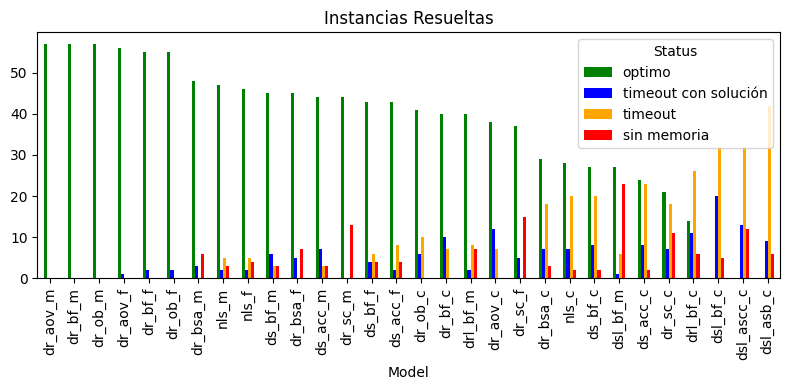

In [101]:
df_models_group1 = metrics_by_model(df_group1, False)

fig, ax = plt.subplots(figsize=(8, 4))
df_models_group1[['status_optimal', 'status_time_limit_solution', 'status_time_limit_no_solution',
                  'status_out_of_memory']].plot(title="Instancias Resueltas", kind='bar', ax=ax, color=['green', 'blue', 'orange', 'red'])
ax.legend(['optimo', 'timeout con solución', 'timeout',
          'sin memoria'], loc='upper right', title="Status")
ax.set_xlabel('Model')
fig.tight_layout()

if save:
    fig.savefig("export/solved_instances_group1.pdf")
    df_models_group1[["solved_%", "one_solved_%", "out_of_memory_%",
                      "time_limit_%"]].to_latex("export/solved_instances_group1.tex")

plt.show()

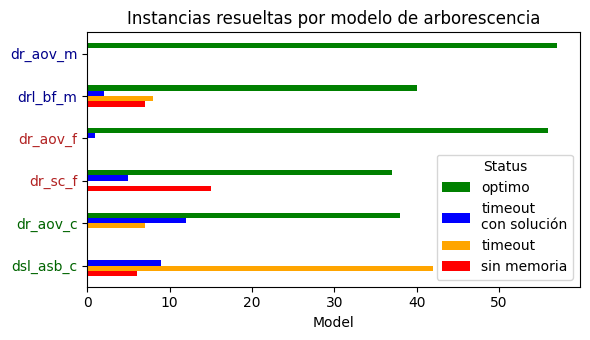

In [144]:
df_models_group1 = metrics_by_model(df_group1, False)

fig, ax = plt.subplots(figsize=(6, 3.5))

models = {
    'dr_aov_m': 'darkblue',
    'drl_bf_m': 'darkblue',
     'dr_aov_f': 'firebrick',
    'dr_sc_f': 'firebrick',
    'dr_aov_c': 'darkgreen',
    'dsl_asb_c': 'darkgreen',
}
important = df_models_group1.filter(items=['dsl_asb_c', 'dr_aov_c', 'dr_sc_f', 'dr_aov_f', 'drl_bf_m', 'dr_aov_m'], axis=0)[[
    'status_out_of_memory',
    'status_time_limit_no_solution',
    'status_time_limit_solution',
    'status_optimal',
    ]]
important.plot(title="Instancias resueltas por modelo de arborescencia", kind='barh',
               ax=ax, color=['red', 'orange', 'blue', 'green'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), [
    'optimo', 
    'timeout\ncon solución',
    'timeout',
    'sin memoria',
    ], loc='lower right', title="Status")
ax.set_xlabel('Model')

for tick in ax.get_yticklabels():
    tick.set_color(models[tick.get_text()])

ax.set_xlabel('Model')
fig.tight_layout()

if save:
    fig.savefig("export/solved_instances_group1_arborescense.pdf")

plt.show()

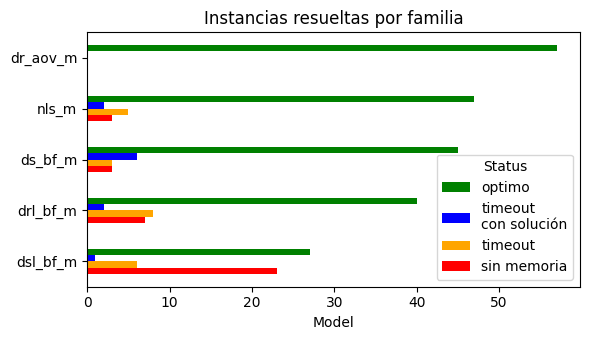

In [142]:
df_models_group1 = metrics_by_model(df_group1, False)

fig, ax = plt.subplots(figsize=(6, 3.5))

models = reversed([
    'dr_aov_m',
    'nls_m',
    'ds_bf_m',
    'drl_bf_m',
    'dsl_bf_m',
])
important = df_models_group1.filter(items=models, axis=0)[[
    'status_out_of_memory',
    'status_time_limit_no_solution',
    'status_time_limit_solution',
    'status_optimal',
    ]]
important.plot(title="Instancias resueltas por familia", kind='barh',
               ax=ax, color=['red', 'orange', 'blue', 'green'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), [
    'optimo', 
    'timeout\ncon solución',
    'timeout',
    'sin memoria',
    ], loc='best', title="Status")
ax.set_xlabel('Model')

ax.set_xlabel('Model')
fig.tight_layout()

if save:
    fig.savefig("export/solved_instances_group1_family.pdf")

plt.show()

### Relative Gap

,model,linear_relaxation_gap
0,dr_aov_m,0.579365
1,dr_bf_m,0.579365
2,dr_ob_m,0.579365
3,nls_m,0.583333
4,ds_bf_m,0.583333
5,ds_acc_m,0.583333
6,drl_bf_m,0.589744
7,dsl_bf_m,0.603175
8,dr_bsa_m,0.607737
9,dr_aov_f,0.608333


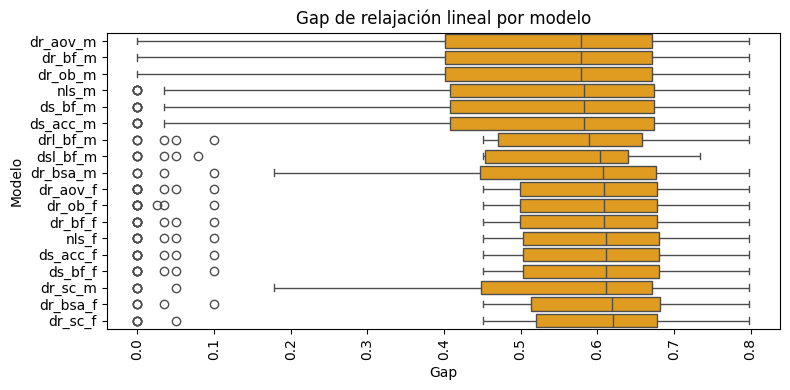

In [203]:
df_relaxation_gap_sorted = df_group1[~df_group1['model'].isin(cut_based)].groupby(
    'model')['linear_relaxation_gap'].median().sort_values()
with pd.option_context('display.max_rows', None):
    display(df_relaxation_gap_sorted.reset_index())

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df_group1, x='linear_relaxation_gap', y='model',
            order=df_relaxation_gap_sorted.index, ax=ax, color='orange')
ax.set_xlabel('Gap')
ax.set_ylabel('Modelo')
plt.xticks(rotation=90)
ax.set_title('Gap de relajación lineal por modelo')
fig.tight_layout()

if save:
    fig.savefig("export/linear_relaxation_gap_group1.pdf")
plt.show()

### Solved Instances Time comparison

We keep the models that solved above 75% instances and compare only on the solved instances for those models. 

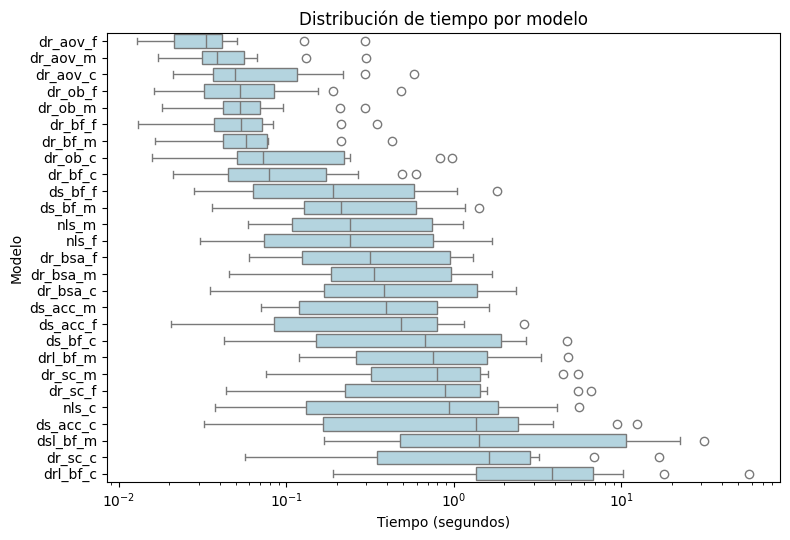

In [204]:
solved_above_75 = list(
    df_models_group1[df_models_group1["solved_%"] >= 0.75].index)
df_solvers = df_group1[(df_group1["model"].isin(solved_above_75))
                       & (df_group1["status"] == "OPTIMAL")]

solved_count = df_solvers.groupby("instance").size()
solved_count = solved_count[solved_count == len(solved_above_75)]

df_solvers = df_solvers[df_solvers["instance"].isin(solved_count.index)]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 5.5))

sns.boxplot(data=df_solvers, y='model', x='time', ax=ax1,
            order=df_solvers.groupby("model")["time"].median().sort_values().index, color='lightblue')
ax1.set_ylabel('Modelo')
ax1.set_xlabel('Tiempo (segundos)')
ax1.set_xscale('log')
ax1.set_title('Distribución de tiempo por modelo')
fig.tight_layout()

if save:
    fig.savefig("export/time_distribution_group1.pdf")
plt.show()

### Variable/Constraints Count Comparison

1) Compare variable counts considering instances that were setup correctly
2) Compare constraints count for all model that solved (maybe not to optimality) at least 50% of the instances
3) Compare the manual added cuts for path generation for cut based models 

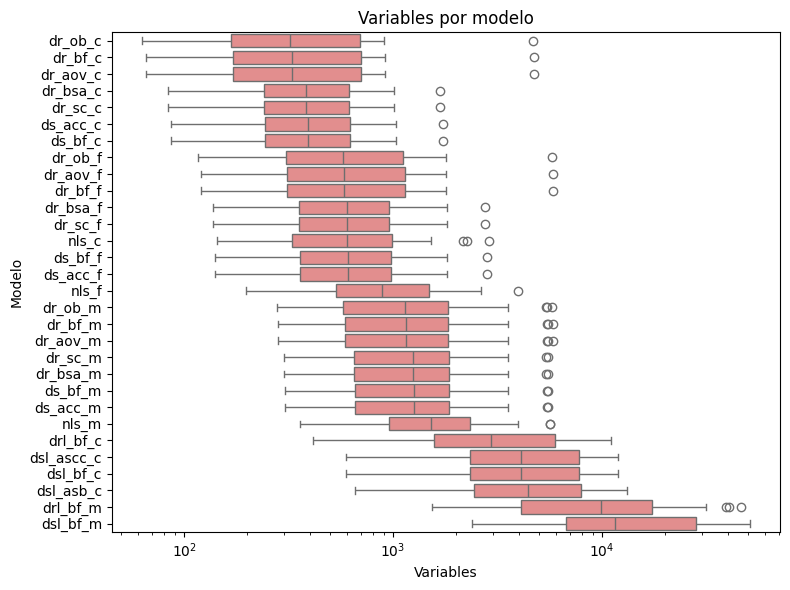

In [205]:
df_setup = df_group1[df_group1["status"] != "OUT_OF_MEMORY"]

setup_count = df_setup.groupby("instance").size()
setup_count = setup_count[setup_count == len(df_group1["model"].unique())]

df_setup = df_setup[df_setup["instance"].isin(setup_count.index)]


one_solved_above_50 = list(
    df_models_group1[df_models_group1["one_solved_%"] >= 0.50].index)
df_one_solved = df_group1[(df_group1["model"].isin(one_solved_above_50)) & (
    df_group1["status"].isin(["OPTIMAL", "TIME_LIMIT_SOLUTION"]))]

one_solved_count = df_one_solved.groupby("instance").size()
one_solved_count = one_solved_count[one_solved_count == len(
    one_solved_above_50)]

df_one_solved = df_one_solved[df_one_solved["instance"].isin(
    one_solved_count.index)]
df_one_solved["constraints_total"] = df_one_solved["constraints"] + \
    df_one_solved["cuts_user"]

fig1, ax1 = plt.subplots(1, 1, figsize=(8, 6))

sns.boxplot(data=df_setup, y='model', x='variables', ax=ax1, order=df_setup.groupby(
    "model")["variables"].median().sort_values().index, color="lightcoral")
ax1.set_ylabel('Modelo')
ax1.set_xlabel('Variables')
ax1.set_xscale('log')
ax1.set_title('Variables por modelo')
fig1.tight_layout()
if save:
    fig1.savefig("export/variables_group1.pdf")

plt.show()

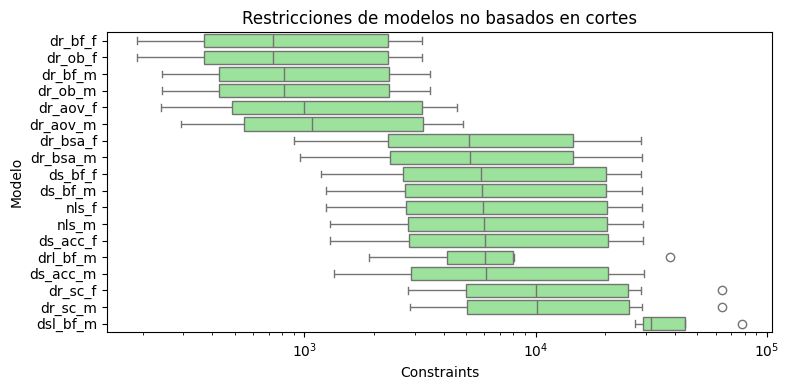

In [206]:
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))

df_one_solved_no_cut = df_one_solved[~df_one_solved["model"].isin(cut_based)]
sns.boxplot(data=df_one_solved_no_cut[df_one_solved_no_cut['constraints_total'] <= df_one_solved_no_cut['constraints_total'].quantile(0.99)], y='model', x='constraints_total',
            ax=ax2, order=df_one_solved_no_cut.groupby("model")["constraints_total"].median().sort_values().index, color='lightgreen')
ax2.ticklabel_format(style='plain', axis='x')
ax2.set_xlabel('Constraints')
ax2.set_ylabel('Modelo')
ax2.set_xscale('log')
ax2.set_title('Restricciones de modelos no basados en cortes')
fig2.tight_layout()

if save:
    fig2.savefig("export/constraints_group1.pdf")

plt.show()

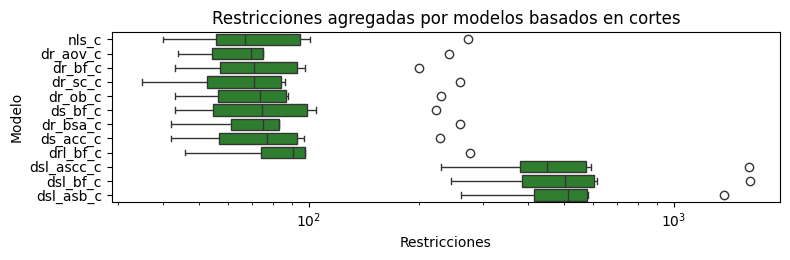

In [207]:

fig3, ax3 = plt.subplots(1, 1, figsize=(8, 2.7))

df_user_cuts = df_one_solved[df_one_solved["model"].isin(cut_based)]
sns.boxplot(data=df_user_cuts, y='model', x='cuts_user', color="forestgreen",
            ax=ax3, order=df_user_cuts.groupby("model")["cuts_user"].median().sort_values().index)
ax3.ticklabel_format(style='plain', axis='x')
ax3.set_xlabel('Restricciones')
ax3.set_ylabel('Modelo')
ax3.set_xscale('log')
ax3.set_title('Restricciones agregadas por modelos basados en cortes')
fig3.tight_layout()

if save:
    fig3.savefig("export/cut_constraints_group1.pdf")
plt.show()

# Group 2
Group 2 includes the best performing models and 513 instances

In [88]:
df_group2 = load_group(2, False)
for t in transformations:
    df_group2 = t(df_group2, False)

df_group2.head()

,quality_metrics,cuts_solution_pool,name,cuts_MIR,cuts_disjunctive,cuts_implied_bound,cuts_fractional,cuts_lift_and_project,cuts_GUB_cover,cuts_clique,cuts_flow_path,cuts_cover,n_iterations,variables_user,variables,n_nodes_processed,cuts_RLT,dettime,best_bound,cuts_zero_half,variables_integer,miprelgap,cuts_benders,solve_status,linear_relaxation,exception,cuts_user,cuts_flow_cover,cuts_local_implied_bound,variables_binary,linear_nonzeros,cuts_table,ncolumns,solve_status_code,constraints,time,problem_type,variables_continuous,cuts_multi_commodity_flow,cuts_BQP,objective_value,group,model,instance,instance_nodes,instance_edges,topology,slots,max_sd,terminals,spread,status,solved_objective_value,linear_relaxation_gap,time_to_nodes_ratio,presolve,demand_density,edge_density
0,{},0.0,dr_bf_m:19n-76m-EON19_10_3_26_0.5,23.0,0.0,0.0,33.0,0.0,0.0,51.0,0.0,117.0,2041,2656,2656,0,0.0,347.318877,39.0,41.0,16,0.0,0.0,integer optimal solution,19.583333,NaN,0.0,1.0,0.0,2640,27904,0.0,2656,101,5402,0.498259,MILP,0,32.0,0.0,39.0,G2,dr_bf_m,19n-76m-EON19_10_3_26_0.5,19,76,EON19,10,3,26,0.5,OPTIMAL,39.0,0.497863,inf,True,0.3,0.222222
1,{},0.0,dr_aov_m:30n-112m-Spain_100_30_24_0.2,36.0,0.0,4.0,19.0,0.0,0.0,93.0,0.0,177.0,3546,3278,3278,0,0.0,369.081859,41.0,61.0,10,0.0,0.0,integer optimal solution,17.531746,NaN,0.0,3.0,0.0,3268,19844,0.0,3278,101,4650,0.571760,MILP,0,37.0,0.0,41.0,G2,dr_aov_m,30n-112m-Spain_100_30_24_0.2,30,112,Spain,100,30,24,0.2,OPTIMAL,41.0,0.572396,inf,True,0.3,0.128736
2,{},0.0,dr_bf_f:6n-9m-n6s9_100_50_12_0.5,3.0,0.0,2.0,4.0,1.0,0.0,0.0,0.0,6.0,99,164,164,0,0.0,18.822218,13.0,2.0,80,0.0,0.0,integer optimal solution,4.750000,NaN,0.0,3.0,0.0,84,1396,0.0,164,101,326,0.063456,MILP,0,6.0,0.0,13.0,G2,dr_bf_f,6n-9m-n6s9_100_50_12_0.5,6,9,n6s9,100,50,12,0.5,OPTIMAL,13.0,0.634615,inf,True,0.5,0.300000
3,{},0.0,dr_bf_f:24n-86m-UBN24_10_5_14_0.2,33.0,0.0,5.0,9.0,0.0,0.0,0.0,1.0,11.0,9563,528,528,369,0.0,293.031195,26.0,65.0,264,0.0,0.0,integer optimal solution,10.625000,NaN,0.0,50.0,0.0,264,3630,0.0,528,101,855,0.443904,MILP,0,9.0,0.0,26.0,G2,dr_bf_f,24n-86m-UBN24_10_5_14_0.2,24,86,UBN24,10,5,14,0.2,OPTIMAL,26.0,0.591346,0.001203,False,0.5,0.155797
4,{},0.0,dr_aov_m:10n-44m-SmallNet_100_30_28_0.5,15.0,0.0,9.0,21.0,0.0,0.0,12.0,0.0,121.0,1630,1782,1782,0,0.0,162.969796,32.0,70.0,20,0.0,0.0,integer optimal solution,20.333333,NaN,0.0,1.0,0.0,1762,23976,0.0,1782,101,6680,0.262249,MILP,0,0.0,0.0,32.0,G2,dr_aov_m,10n-44m-SmallNet_100_30_28_0.5,10,44,SmallNet,100,30,28,0.5,OPTIMAL,32.0,0.364583,inf,True,0.3,0.488889


### Solved instances

In [89]:
get_instances(df_group2, True)

,edge_density,instance_nodes,instance_edges,slots,max_sd,topology,spread,terminals,group
432,0.300000,6,9,10,1,n6s9,0.2,60,G2
280,0.300000,6,9,10,1,n6s9,0.5,60,G2
1236,0.300000,6,9,10,1,n6s9,1.0,60,G2
197,0.300000,6,9,10,3,n6s9,0.2,20,G2
310,0.300000,6,9,10,3,n6s9,0.5,20,G2
...,...,...,...,...,...,...,...,...,...
946,0.097453,43,176,100,30,EuroLarge,0.5,26,G2
543,0.097453,43,176,100,30,EuroLarge,1.0,26,G2
283,0.097453,43,176,100,50,EuroLarge,0.2,16,G2
155,0.097453,43,176,100,50,EuroLarge,0.5,16,G2


,edge_density,instance_nodes,instance_edges,slots,max_sd,spread,terminals
count,513.000000,513.000000,513.000000,513.000000,513.00000,513.000000,513.000000
mean,0.210643,20.157895,69.210526,46.666667,14.00000,0.566667,34.526316
std,0.106293,8.185378,33.164577,38.623786,15.23911,0.330305,25.260436
min,0.089947,6.000000,9.000000,10.000000,1.00000,0.200000,8.000000
25%,0.151515,14.000000,46.000000,10.000000,3.00000,0.200000,14.000000
50%,0.185714,20.000000,70.000000,30.000000,9.00000,0.500000,22.000000
75%,0.230769,24.000000,78.000000,100.000000,15.00000,1.000000,60.000000
max,0.488889,43.000000,176.000000,100.000000,50.00000,1.000000,94.000000


,edge_density,instance_nodes,instance_edges,slots,max_sd,topology,spread,terminals,group
432,0.300000,6,9,10,1,n6s9,0.2,60,G2
280,0.300000,6,9,10,1,n6s9,0.5,60,G2
1236,0.300000,6,9,10,1,n6s9,1.0,60,G2
197,0.300000,6,9,10,3,n6s9,0.2,20,G2
310,0.300000,6,9,10,3,n6s9,0.5,20,G2
...,...,...,...,...,...,...,...,...,...
946,0.097453,43,176,100,30,EuroLarge,0.5,26,G2
543,0.097453,43,176,100,30,EuroLarge,1.0,26,G2
283,0.097453,43,176,100,50,EuroLarge,0.2,16,G2
155,0.097453,43,176,100,50,EuroLarge,0.5,16,G2


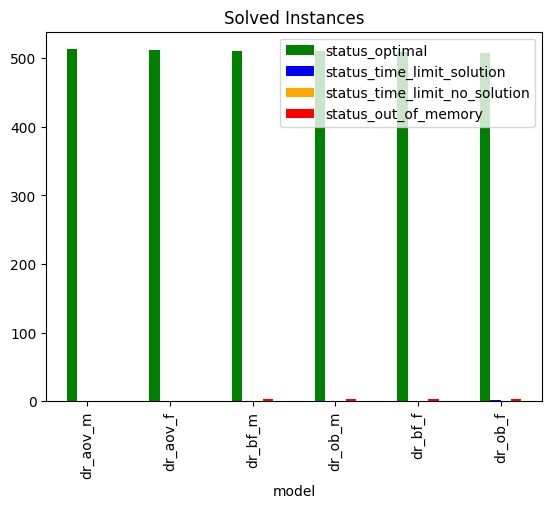

In [102]:
df_models_group2 = metrics_by_model(df_group2, False)

fig, ax = plt.subplots()
df_models_group2[['status_optimal', 'status_time_limit_solution', 'status_time_limit_no_solution',
                  'status_out_of_memory']].plot(title="Solved Instances", kind='bar', ax=ax, color=['green', 'blue', 'orange', 'red'])

plt.show()

In [138]:
df_group2[df_group2["status"] == "OUT_OF_MEMORY"][["model", "topology",
                                                   "max_sd", "slots", "instance_nodes", "instance_edges", "terminals", "spread"]]

,model,topology,max_sd,slots,instance_nodes,instance_edges,terminals,spread
64,dr_bf_f,EuroLarge,1,10,43,176,80,1.0
81,dr_bf_m,EuroLarge,1,10,43,176,80,1.0
615,dr_ob_f,EuroLarge,1,10,43,176,80,1.0
1018,dr_bf_m,EuroLarge,3,30,43,176,80,1.0
1192,dr_bf_m,EuroLarge,10,100,43,176,80,1.0
1498,dr_ob_f,EuroLarge,10,100,43,176,80,1.0
1520,dr_bf_f,EuroLarge,10,100,43,176,80,1.0
1566,dr_bf_f,EuroLarge,3,30,43,176,80,1.0
2125,dr_ob_m,EuroLarge,1,10,43,176,80,1.0
2135,dr_ob_f,EuroLarge,3,30,43,176,80,1.0


,model,linear_relaxation_gap
0,dr_aov_m,0.385405
1,dr_bf_m,0.397059
2,dr_ob_m,0.397247
3,dr_aov_f,0.500000
4,dr_bf_f,0.500000
5,dr_ob_f,0.500000


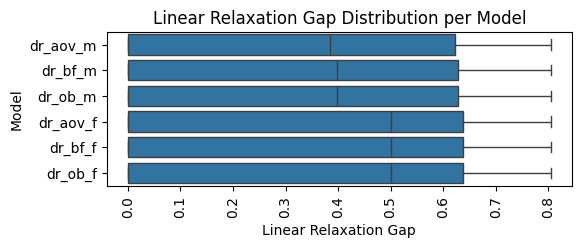

In [103]:
df_relaxation_gap_sorted = df_group2.groupby(
    'model')['linear_relaxation_gap'].median().sort_values()
with pd.option_context('display.max_rows', None):
    display(df_relaxation_gap_sorted.reset_index())

fig, ax = plt.subplots(figsize=(6, 2))
sns.boxplot(data=df_group2, x='linear_relaxation_gap', y='model',
            order=df_relaxation_gap_sorted.index, ax=ax)
plt.xlabel('Linear Relaxation Gap')
plt.ylabel('Model')
plt.xticks(rotation=90)
plt.title('Linear Relaxation Gap Distribution per Model')
plt.show()

### Solved Instances Time comparison

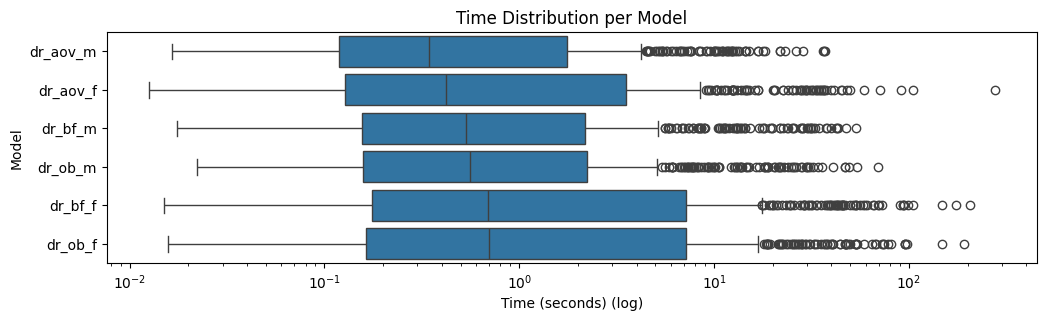

In [104]:
df_solvers = df_group2[df_group2["status"] == "OPTIMAL"]

fig, ax1 = plt.subplots(1, 1, figsize=(12, 3))

sns.boxplot(data=df_solvers, y='model', x='time', ax=ax1,
            order=df_solvers.groupby("model")["time"].median().sort_values().index)
ax1.set_ylabel('Model')
ax1.set_xlabel('Time (seconds) (log)')
ax1.set_xscale('log')
plt.xticks(rotation=0)
ax1.set_title('Time Distribution per Model')
plt.show()

### Presolved

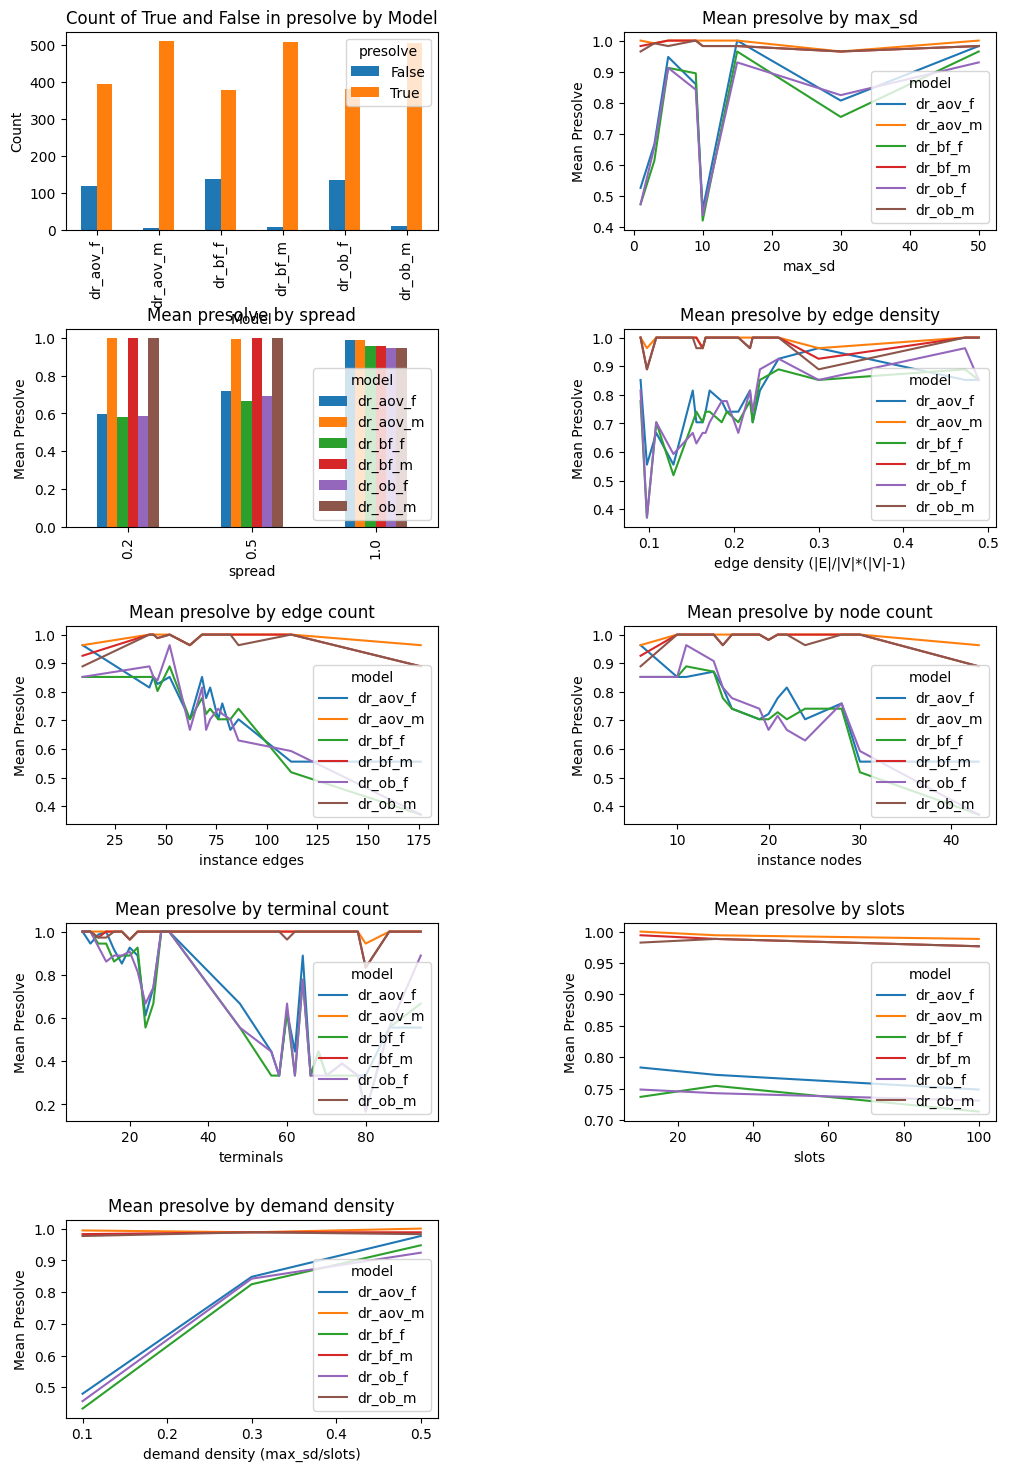

In [159]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

ax0 = ax[0, 0]
df_group2.groupby(["model", "presolve"]).size(
).unstack().plot(kind='bar', ax=ax0)
ax0.set_xlabel('Model')
ax0.set_ylabel('Count')
ax0.set_title('Count of True and False in presolve by Model')
ax0.legend(title='presolve', loc='upper right')

ax1 = ax[0, 1]
df_group2.groupby(["max_sd", "model"])[
    "presolve"].mean().unstack().plot(kind='line', ax=ax1)
ax1.set_xlabel('max_sd')
ax1.set_ylabel('Mean Presolve')
ax1.set_title('Mean presolve by max_sd')
ax1.legend(title='model', loc='lower right')

ax2 = ax[1, 0]
df_group2.groupby(["spread", "model"])[
    "presolve"].mean().unstack().plot(kind='bar', ax=ax2)
ax2.set_xlabel('spread')
ax2.set_ylabel('Mean Presolve')
ax2.set_title('Mean presolve by spread')
ax2.legend(title='model', loc='lower right')

ax3 = ax[1, 1]
df_group2.groupby(["edge_density", "model"])[
    "presolve"].mean().unstack().plot(kind='line', ax=ax3)
ax3.set_xlabel('edge density (|E|/|V|*(|V|-1)')
ax3.set_ylabel('Mean Presolve')
ax3.set_title('Mean presolve by edge density')
ax3.legend(title='model', loc='lower right')

ax4 = ax[2, 0]
df_group2.groupby(by=["instance_edges", "model"])[
    "presolve"].mean().unstack().plot(kind='line', ax=ax4)
ax4.set_xlabel('instance edges')
ax4.set_ylabel('Mean Presolve')
ax4.set_title('Mean presolve by edge count')
ax4.legend(title='model', loc='lower right')

ax5 = ax[2, 1]
df_group2.groupby(by=["instance_nodes", "model"])[
    "presolve"].mean().unstack().plot(kind='line', ax=ax5)
ax5.set_xlabel('instance nodes')
ax5.set_ylabel('Mean Presolve')
ax5.set_title('Mean presolve by node count')
ax5.legend(title='model', loc='lower right')

ax6 = ax[3, 0]
df_group2.groupby(by=["terminals", "model"])[
    "presolve"].mean().unstack().plot(kind='line', ax=ax6)
ax6.set_xlabel('terminals')
ax6.set_ylabel('Mean Presolve')
ax6.set_title('Mean presolve by terminal count')
ax6.legend(title='model', loc='lower right')

ax7 = ax[3, 1]
df_group2.groupby(by=["slots", "model"])[
    "presolve"].mean().unstack().plot(kind='line', ax=ax7)
ax7.set_xlabel('slots')
ax7.set_ylabel('Mean Presolve')
ax7.set_title('Mean presolve by slots')
ax7.legend(title='model', loc='lower right')

ax8 = ax[4, 0]
df_group2.groupby(by=["demand_density", "model"])[
    "presolve"].mean().unstack().plot(kind='line', ax=ax8)
ax8.set_xlabel('demand density (max_sd/slots)')
ax8.set_ylabel('Mean Presolve')
ax8.set_title('Mean presolve by demand density')
ax8.legend(title='model', loc='lower right')

fig.delaxes(ax[4, 1])
plt.show()

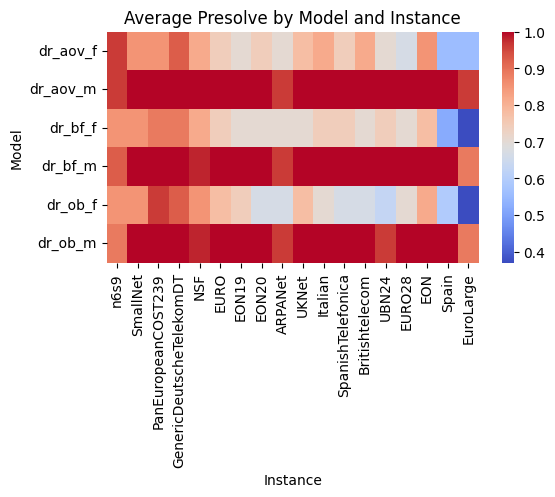

In [213]:
instances = get_instances(df_group2, False).groupby("topology")[
    "instance_nodes"].mean().sort_values()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
df_presolve_avg = df_group2.groupby(['model', 'topology'])[
    'presolve'].mean().unstack()
df_presolve_avg = df_presolve_avg.reindex(instances.index, axis=1)

sns.heatmap(df_presolve_avg, cmap='coolwarm', ax=ax)
ax.set_xlabel('Instance')
ax.set_ylabel('Model')
ax.set_title('Average Presolve by Model and Instance')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### Solved Instance Time Comparison

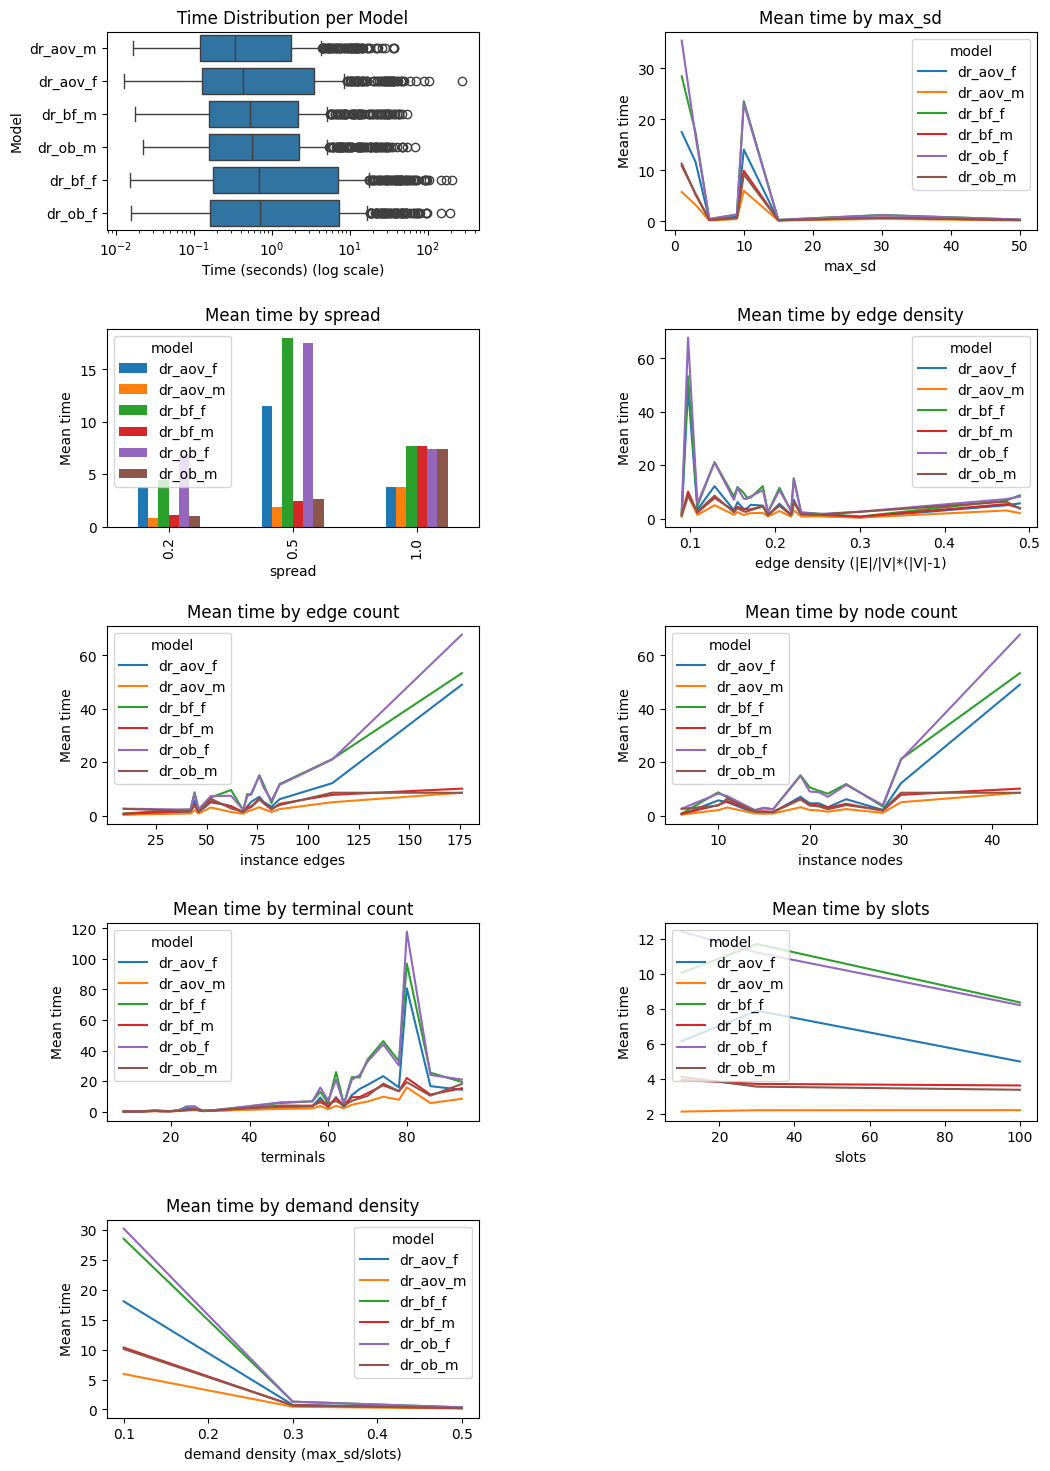

In [162]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

ax0 = ax[0, 0]
sns.boxplot(data=df_solvers, y='model', x='time', ax=ax0,
            order=df_solvers.groupby("model")["time"].median().sort_values().index)
ax0.set_ylabel('Model')
ax0.set_xlabel('Time (seconds) (log scale)')
ax0.set_xscale('log')
ax0.set_title('Time Distribution per Model')

ax1 = ax[0, 1]
df_group2.groupby(["max_sd", "model"])[
    "time"].mean().unstack().plot(kind='line', ax=ax1)
ax1.set_xlabel('max_sd')
ax1.set_ylabel('Mean time')
ax1.set_title('Mean time by max_sd')
ax1.legend(title='model', loc='upper right')

ax2 = ax[1, 0]
df_group2.groupby(["spread", "model"])[
    "time"].mean().unstack().plot(kind='bar', ax=ax2)
ax2.set_xlabel('spread')
ax2.set_ylabel('Mean time')
ax2.set_title('Mean time by spread')
ax2.legend(title='model', loc='upper left')

ax3 = ax[1, 1]
df_group2.groupby(["edge_density", "model"])[
    "time"].mean().unstack().plot(kind='line', ax=ax3)
ax3.set_xlabel('edge density (|E|/|V|*(|V|-1)')
ax3.set_ylabel('Mean time')
ax3.set_title('Mean time by edge density')
ax3.legend(title='model', loc='upper right')

ax4 = ax[2, 0]
df_group2.groupby(by=["instance_edges", "model"])[
    "time"].mean().unstack().plot(kind='line', ax=ax4)
ax4.set_xlabel('instance edges')
ax4.set_ylabel('Mean time')
ax4.set_title('Mean time by edge count')
ax4.legend(title='model', loc='upper left')

ax5 = ax[2, 1]
df_group2.groupby(by=["instance_nodes", "model"])[
    "time"].mean().unstack().plot(kind='line', ax=ax5)
ax5.set_xlabel('instance nodes')
ax5.set_ylabel('Mean time')
ax5.set_title('Mean time by node count')
ax5.legend(title='model', loc='upper left')

ax6 = ax[3, 0]
df_group2.groupby(by=["terminals", "model"])[
    "time"].mean().unstack().plot(kind='line', ax=ax6)
ax6.set_xlabel('terminals')
ax6.set_ylabel('Mean time')
ax6.set_title('Mean time by terminal count')
ax6.legend(title='model', loc='upper left')

ax7 = ax[3, 1]
df_group2.groupby(by=["slots", "model"])[
    "time"].mean().unstack().plot(kind='line', ax=ax7)
ax7.set_xlabel('slots')
ax7.set_ylabel('Mean time')
ax7.set_title('Mean time by slots')
ax7.legend(title='model', loc='upper left')


ax8 = ax[4, 0]
df_group2.groupby(by=["demand_density", "model"])[
    "time"].mean().unstack().plot(kind='line', ax=ax8)
ax8.set_xlabel('demand density (max_sd/slots)')
ax8.set_ylabel('Mean time')
ax8.set_title('Mean time by demand density')
ax8.legend(title='model', loc='upper right')

fig.delaxes(ax[4, 1])

plt.show()

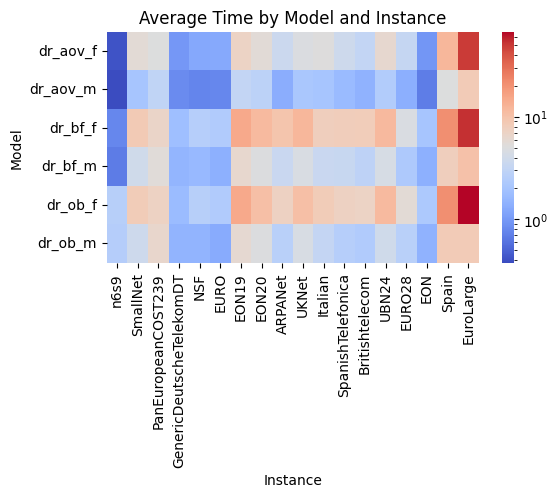

In [208]:
instances = get_instances(df_group2, False).groupby("topology")[
    "instance_nodes"].mean().sort_values()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
df_presolve_avg = df_group2.groupby(['model', 'topology'])[
    'time'].mean().unstack()
df_presolve_avg = df_presolve_avg.reindex(instances.index, axis=1)
sns.heatmap(df_presolve_avg, cmap='coolwarm',
            ax=ax, norm=matplotlib.colors.LogNorm())
ax.set_xlabel('Instance')
ax.set_ylabel('Model')
ax.set_title('Average Time by Model and Instance')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### Variable/Constraints Count Comparison

Compare variable and constraint counts considering instances that were setup correctly

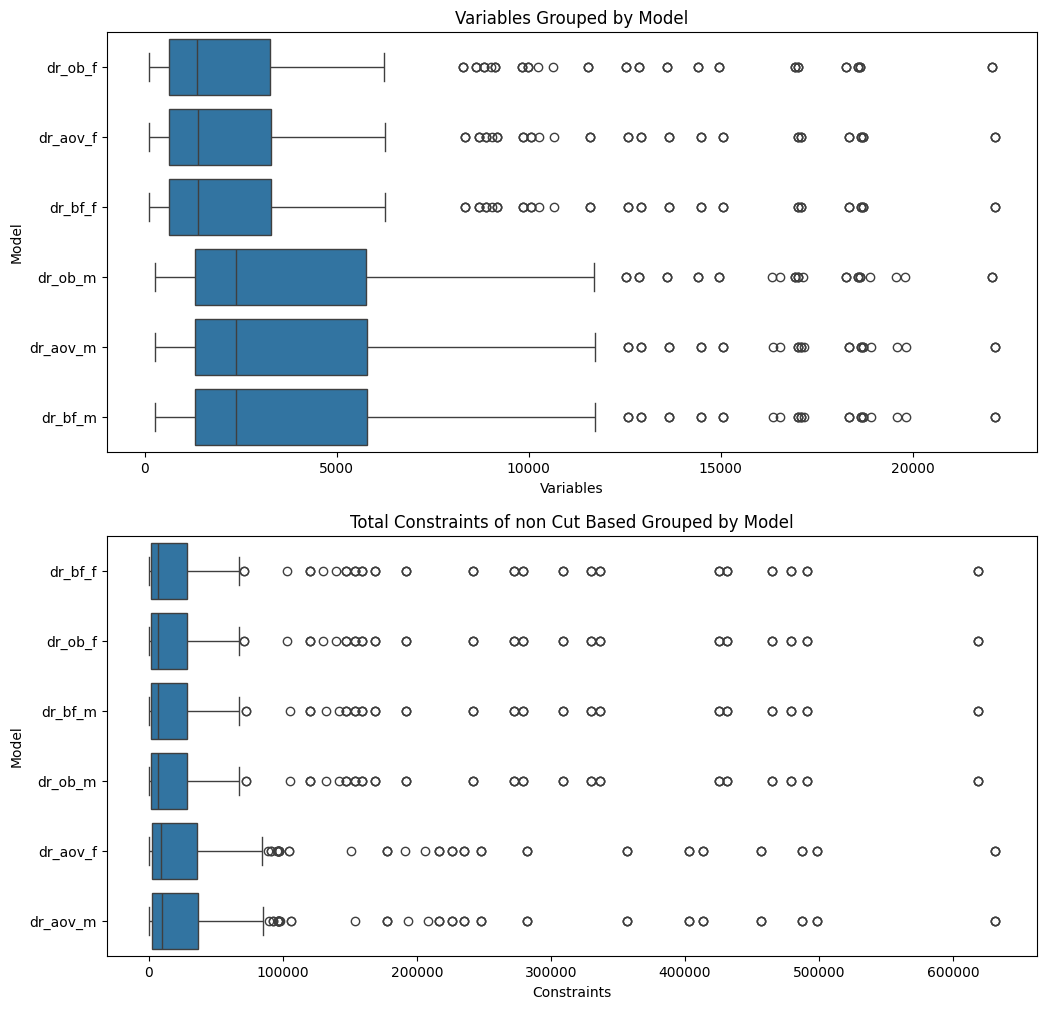

In [129]:
df_setup = df_group2[df_group2["status"] != "OUT_OF_MEMORY"]

setup_count = df_setup.groupby("instance").size()
setup_count = setup_count[setup_count == len(df_group2["model"].unique())]

df_setup = df_setup[df_setup["instance"].isin(setup_count.index)]


df_setup["constraints_total"] = df_setup["constraints"] + \
    df_setup["cuts_user"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.boxplot(data=df_setup, y='model', x='variables', ax=ax1, order=df_setup.groupby(
    "model")["variables"].median().sort_values().index)
ax1.set_ylabel('Model')
ax1.set_xlabel('Variables')
ax1.set_title('Variables Grouped by Model')
plt.xticks(rotation=90)

sns.boxplot(data=df_setup[df_setup['constraints_total'] <= df_setup['constraints_total'].quantile(0.99)], y='model', x='constraints_total',
            ax=ax2, order=df_setup.groupby("model")["constraints_total"].median().sort_values().index)
plt.xticks(rotation=0)
ax2.ticklabel_format(style='plain', axis='x')
ax2.set_xlabel('Constraints')
ax2.set_ylabel('Model')
ax2.set_title('Total Constraints of non Cut Based Grouped by Model')

plt.show()